## File created by Reid Wyde


### Last updated 9.10.19

### TODO


#### short term

Make an account for tack (the cluster)

Send Ernesto the user ID

Think up drug drug interaction term

change allee to be data based (lowest initial volume)

change treatment that is associated with the allee effect to be higher (2 orders of magnitude)

add model classes for all growth equations

adjust parameters for models 6+


#### mid term

look at how likelihood is fit/punished (the objective function for pymc3)

add BIC and configure pymc3 for posterior information criterion

visualization on gelman rubin

investigate maximum likelihood parameter sample



#### long term

drug-drug interaction

figure out why nuts fails to initialize

configure theano for multiple cores // windows issue, not possible right now



# Data driven growth models for Adjuvant Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth, provided by Dr. Ernesto Lima, The Center for Computational Oncology at The University of Texas, 2019. 

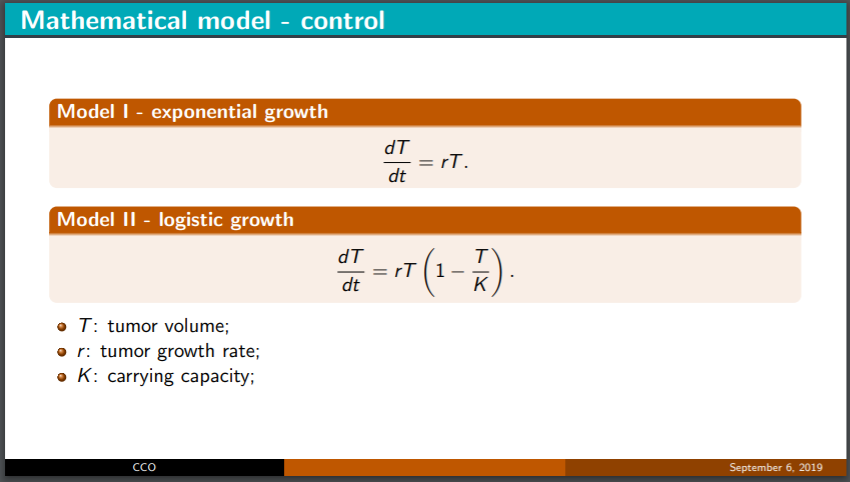

## Model I - exponential growth
dTdt = rT

## Model 2 - logistic growth
dTdt = rT(1-T/K)

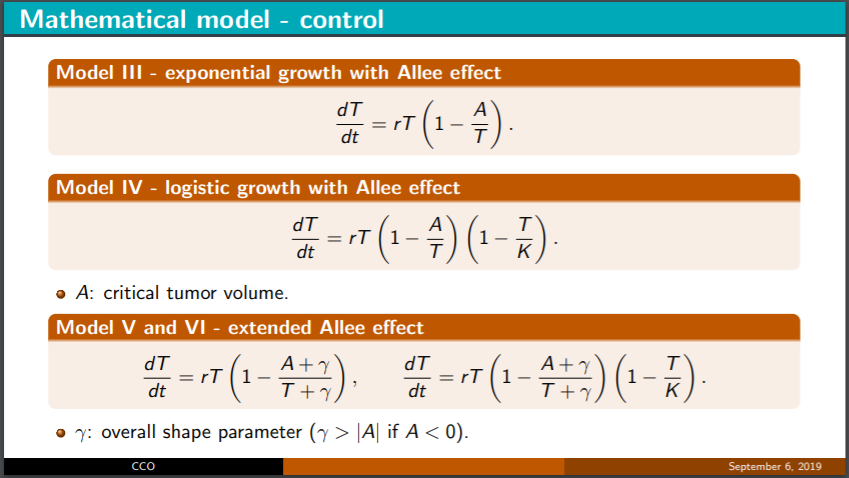

## Model 3 - exponential allee growth
dTdt = r*T*(1-A/T)

## Model 4 - logistic allee growth
dTdt = r*T*(1-A/T)*(1-T/K)

## Model 5 - exponential allee growth 
dTdt = r*T(1-(A+gamma)/(T+gamma))

## Model 6 - logistic allee growth
dTdt = r*T(1-(A+gamma)/(T+gamma))*(1-T/K)

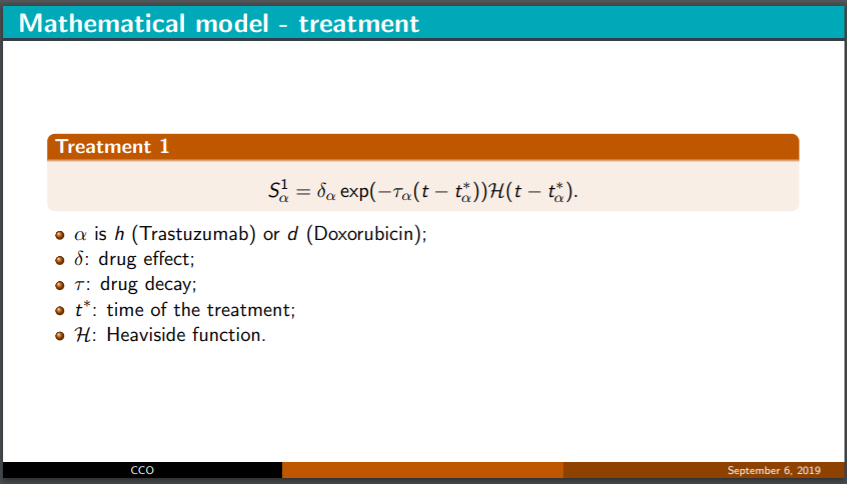

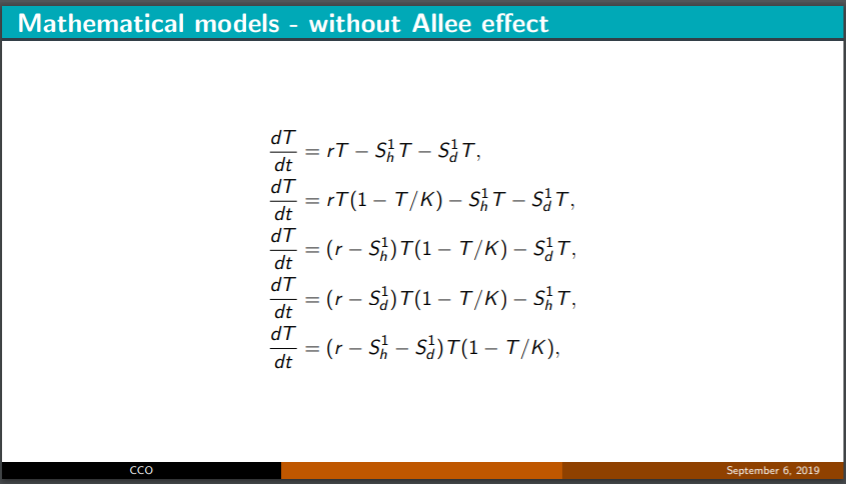

#### model 1 - exponential growth with treatment
dTdt = rT - ShT - SdT

#### model 2 - logistic growth with treatment 
dTdt = rT(1-T/K) - ShT - SdT

#### model 3 - logistic growth with treatment 2
dTdt = (r-Sh)T(1-T/K) - SdT

#### model 4 - logistic growth with treatment 3
dTdt = (r-Sd)T(1-T/K) - ShT

#### model 5 - logistic growth with treatment 4
dTdt = (r-Sh-Sd)T(1-T/K)

## Allee Effect

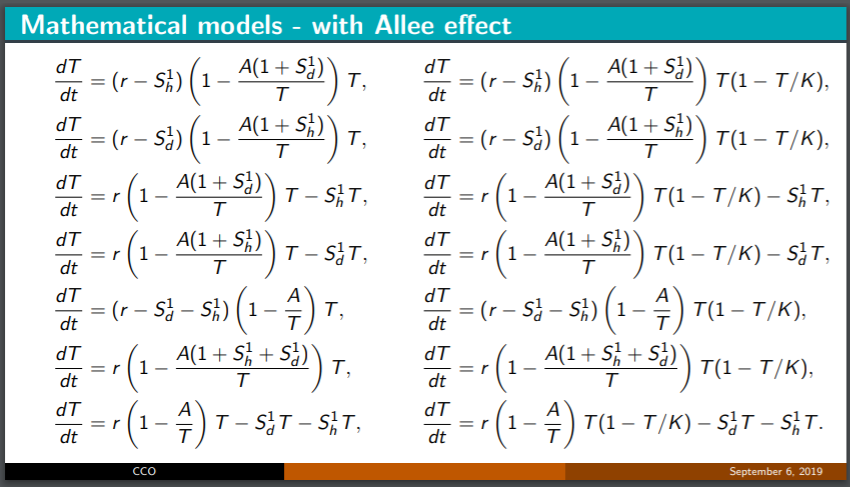

## Allee effect models cont'd

### Left column

#### Model 6
dTdt = (r-Sh)(1-A(1+Sd)/T)T

#### Model 7
dTdt = (r-Sd)(1-A(1+Sh)/T)T

#### Model 8
dTdt = r(1-A(1+Sd)/T)T-ShT

#### Model 9
dTdt = r(1-A(1+Sh)/T)T-SdT

#### Model 10
dTdt = (r-Sd-Sh)(1-A/T)T

#### Model 11
dTdt = r(1-A(1+Sh+Sd)/T)T

#### Model 12
dTdt = r(1-A/T)T - SdT - ShT



### right column

#### Model 13
dTdt = (r-Sh)(1-A(1+Sd)/T)T(1-T/K)

#### Model 14
dTdt = (r-Sd)(1-A(1+Sh)/T)T(1-T/K)

#### Model 15
dTdt = r(1-A(1+Sd)/T)T(1-T/K)-ShT

#### Model 16
dTdt = r(1-A(1+Sh)/T)T(1-T/K)-SdT

#### Model 17
dTdt = (r-Sd-Sh)(1-A/T)T(1-T/K)

#### Model 18
dTdt = r(1-A(1+Sh+Sd)/T)T(1-T/K)

#### Model 19
dTdt = r(1-A/T)T(1-T/K)-SdT-ShT



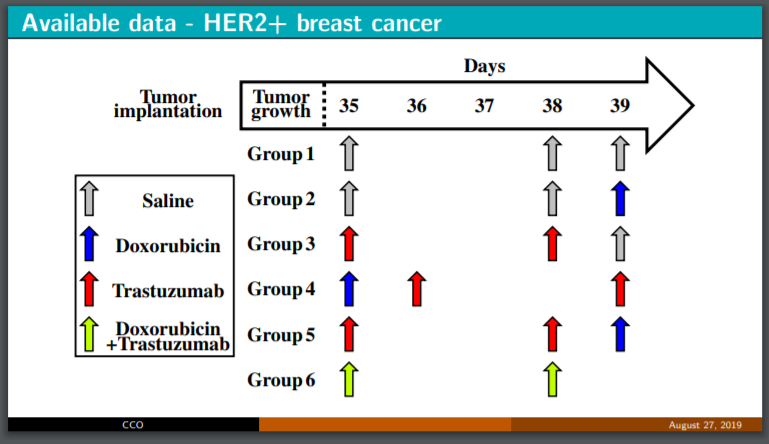

### Other growth models for potential investigation, from Skehan et al. 1984


<div>
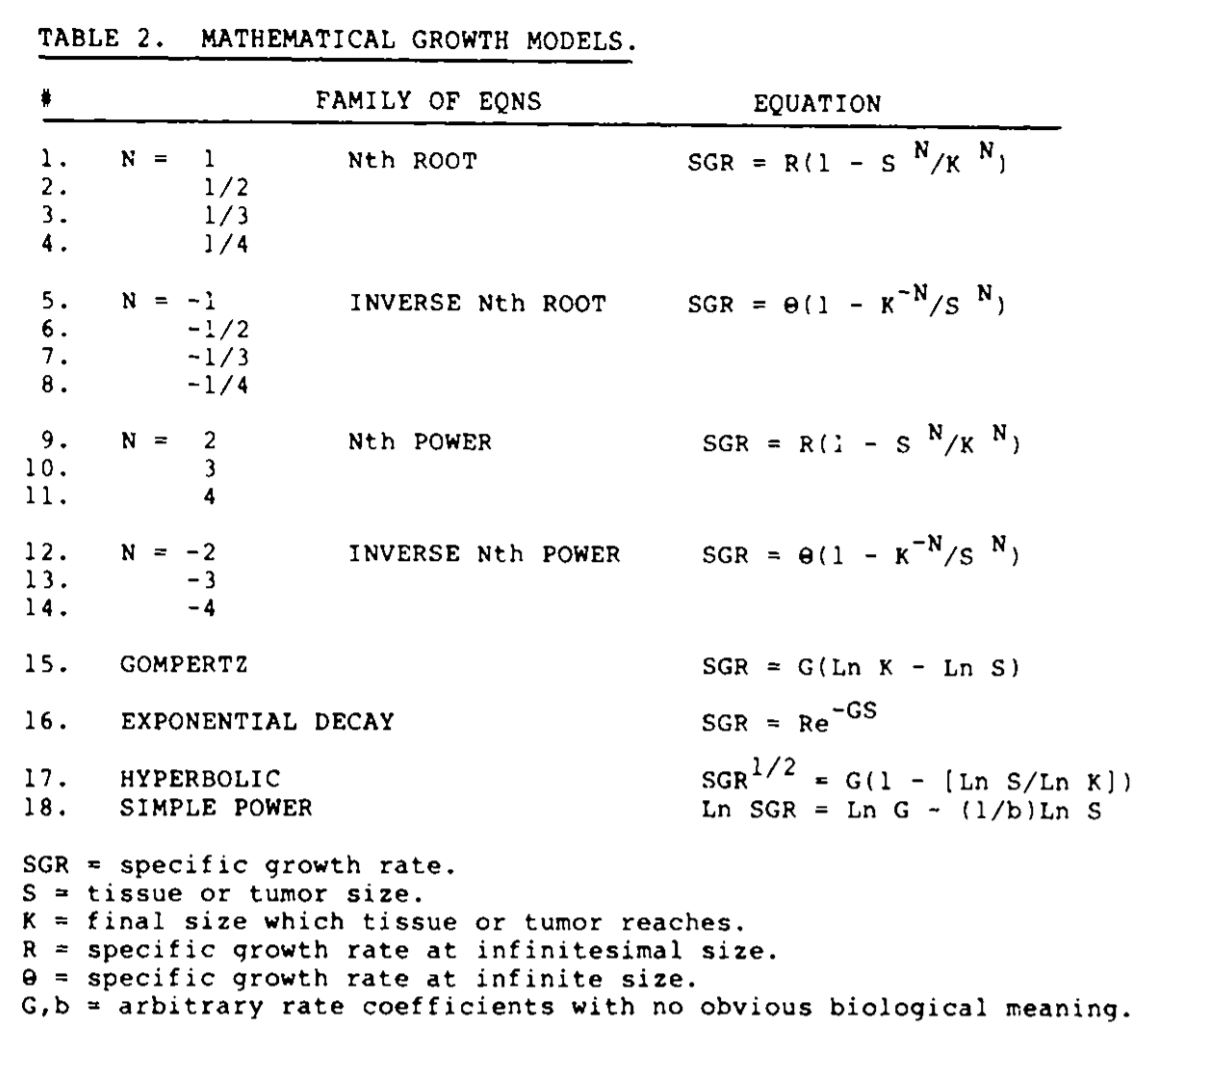
</div>

# Code

In [1]:
## Generalized algorithm



# For each eqn
    # sample priors
    # for each group
        # params_switch(eqn, group)
        # forward(param_switch, eqn, group, priors)
        # likelihood(group, forward)
    #sum(likelihood(groups))



In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.integrate import odeint



plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline

np.random.seed(123)

In [3]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'
tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,53.973689,19.464756,27.939597,19.032486,44.872119,20.290405,38.955318,21.359080,30.988742,17.752230,42.366388,13.069455
1,14,56.730533,34.316923,47.079148,26.709641,59.175717,41.133786,39.697439,29.993253,34.640653,25.398323,52.488467,23.978783
2,23,90.677211,51.384002,61.140151,31.821015,112.524376,51.204812,75.404253,68.348904,61.905680,33.892752,118.747997,71.618255
3,29,182.971051,96.268908,127.343047,61.519414,211.247381,127.305794,217.351729,153.788112,134.994293,65.107710,182.961115,103.520392
4,34,284.888364,147.891820,225.843888,92.229404,346.168185,147.788359,388.344451,247.451969,257.324806,123.482982,267.228868,140.192699


In [4]:
ts = np.array(tumor_size_db['Day']).reshape(-1,1)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

In [5]:
#set of variables

#fitted
#r, double
#K, double
#A, double
#delta, double
#tau, double

#dependent variables
#St, array of doubles
#Sd, array of doubles

#constants
#ts, array of ints
#T, double
#tt_dox, tuple of ints
#tt_tras, tuple of ints


#booleans per group
#group 1
#r=1, K=1, A=1, St=0, Sd=0
#group 2
#r=1, K=1, A=1, St=0, Sd=1
#group 3
#r=1, K=1, A=1, St=1, Sd=0
#group 4
#r=1, K=1, A=1, St=1, Sd=0
#group 5
#r=1, K=1, A=1, St=1, Sd=1
#group 6
#r=1, K=1, A=1, St=1, Sd=1



In [6]:
def unit(x):
    if x>=0: return 1
    return 0

def get_tt(tuple_treatment_group):
    switcher={
        ('dox',2): [39],
        
        ('her',3): [35,38],
        
        ('dox',4): [35],
        ('her',4): [36,39],
        
        ('her',5): [35,38],
        ('dox',5): [39],
        
        ('her',6): [35,38],
        ('dox',6): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])
"""
#S = delta*T*exp(-tau(t-tt))unit(t-tt)
def treatment(delta, Ts, tau, ts, treatment_times, ret_t=False):
    S = np.zeros(ts.shape)
    for t in ts:
        if len(treatment_times) != 0:
            T = Ts[t]
            for tt in treatment_times:
                #print(S[t])
                #print(unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)))
                S[t] = S[t] + unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)) #the 0.0001 reflects that treatment was given just after measuremens on treatment days
                #print('S at ' + str(t) + ' is:' + str(S[t]))
    if ret_t: return ts, S.reshape(-1,1)
    return S.reshape(-1,1)


def dox_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('dox',group))
    Sd = treatment(delta, Ts, tau, ts, treatment_times)
    return Sd
    

def tras_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('tras',group))
    St = treatment(delta, Ts, tau, ts, treatment_times)
    return St

def dox_treatment_all(delta, Ts_all, tau, ts):
    Sd = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        Sd[group] = dox_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return Sd   
    
def tras_treatment_all(delta, Ts_all, tau, ts):
    St = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        St[group] = tras_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return St

"""




def treatment_inst(delta, T, tau, t, treatment_times):
    if len(treatment_times) == 0: return 0
    S = 0
    for tt in treatment_times:
        if unit(t-tt-0.0001):
            S = S + delta*np.exp(-tau*(t-tt)) 
        if math.isnan(S): 
            print('nan treatment')
            print('tau*(t-tt) ' + str(tau*(t-tt)))
            print('T: ' + str(T))
            print('t: ' + str(t))
            print('tt: ' + str(tt))
            print('tau: ' + str(tau))
    return S

def dox_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('dox',group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)
    
def her_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('her', group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)

def dox_treatment_all_inst(delta, T_all, tau, t):
    Sd = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        Sd[group] = dox_treatment_inst(delta, T, tau, t, group)
    return Sd

def her_treatment_all_inst(delta, T_all, tau, t):
    Sh = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        Sh[group] = her_treatment_inst(delta, T, tau, t, group)
    return Sh

In [7]:

def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.errorbar(tumor_size_db['Day'], Ts[ii], sigmas[ii],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[ii])
        plt.title('G' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('Size')
    plt.show()
    

def graph_dox(sim_times, dox):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, dox[ii])
        plt.title('Dox ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()
    
def graph_her(sim_times, her):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, her[ii])
        plt.title('her ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()
    


#### Treatment calculation unit tests

In [8]:


def test_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = (10,40)
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.show()
    return

def test_treatment_2():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('dox',2))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G2 Dox')
    plt.show()
    return


def test_treatment_3():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('her',3))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G3 Her')
    plt.show()
    return

def test_all_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    Ts[1] = np.zeros((1, len(ts.ravel())))
    
    dox = dox_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(dox)):
        row = dox[ii]
        plt.plot(ts, row)
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
        
    her = her_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(her)):
        row = her[ii]
        plt.plot(ts, row)
        plt.title('Her, Group ' + str(ii+1))
        plt.show()
        

def test_all_treatment_inst():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    dox = np.zeros(Ts.shape)
    her = np.zeros(Ts.shape)
    for t in ts:
        T_all = Ts[:,t]
        dox[:,t] = dox_treatment_all_inst(delta, T_all, tau, t)
        her[:,t] = her_treatment_all_inst(delta, T_all, tau, t)
    
    for ii in range(len(dox)):
        plt.plot(ts, dox[ii])
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
     
    for ii in range(len(her)):
        plt.plot(ts, her[ii])
        plt.title('Her, Group ' + str(ii+1))
        plt.show()
        
    

In [9]:
#test_treatment()
#test_treatment_2()
#test_treatment_3()
#test_all_treatment()
#test_all_treatment_inst()

In [10]:

def rungeKutta(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((6, time_len))
    ret[:,0] = T0
    T = T0
    for i in range(1,time_len):
        T = T.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params) 
        k4 = h * dTdt(t+h, T + k3, params) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        if np.float('-inf') in T: 
            print('divergence in rk')
            print('t0 ' + str(t0))
            print('t ' + str(t))
            print('h ' + str(h))
            print('k1 ' + str(k1))
            print('k2 ' + str(k2))
            print('k3 ' + str(k3))
            print('k4 '  + str(k4))
            print('T ' + str(T))
        ret[:,i] = T.clip(min=0)
    return ret

class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0

    def _simulate(self, params, times):
        #values = odeint(self.dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, self._T0, self.dTdt, params)

        return values
   
    def get_param(self, param_name, n=50):
        return sum(self.trace[param_name][-n:])/n

    def get_treatment_params(self):
        delta_d = self.get_param('delta_d')
        delta_h = self.get_param('delta_h')
        tau_d = self.get_param('tau_d')
        tau_h = self.get_param('tau_h')
        return [delta_d, delta_h, tau_d, tau_h]
    
sim_times = np.linspace(7,70,70-7+1)

In [11]:
#### exp
#dTdt = rT - StT - SdT


def fit_sim_graph_model(model_class):
    this_model = model_class(ts, Ts[:,0])
    this_model.backward(Ts, sigmas)
    #delta_d, delta_h, tau_d, tau_h = this_model.get_treatment_params()
    #T_sim = this_model.simulate([this_model.get_param(x) for x in this_model.param_list])
    
    r, delta_d, delta_h, tau_d, tau_h= [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(r, delta_d, delta_h, tau_d, tau_h, sim_times)
    
    dox = np.zeros((6,len(sim_times.ravel())))
    her = np.zeros((6,len(sim_times.ravel())))
    for ii in range(len(sim_times)):
        T = T_sim[:,ii]
        t = sim_times[ii]
        dox[:,ii] = dox_treatment_all_inst(delta_d, T, tau_d, t)
        her[:,ii] = her_treatment_all_inst(delta_h, T, tau_h, t)
    graph_sim(sim_times, T_sim)
    graph_dox(sim_times, dox)
    graph_her(sim_times, her)

import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  ## potential bug fix for slice, don't know if it matters anymore after solving divergence

class exp_growth_model(growth_model):

    def simulate(self, r, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params): 
        T.clip(min=0) #logically 
        r, delta_d, delta_h, tau_d, tau_h = [x for x in params]
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)  #concentration is independent of volume
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r - Sd - Sh)*T
    
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            r_lower = 0.03
            r_upper = 0.07
            delta_d_lower = 0
            delta_d_upper = 5
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 8
            tau_h_lower = -0.1
            tau_h_upper = 0.05

            r = pm.Uniform('r', lower=r_lower, upper=r_upper)           
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)

            self.param_list=['r','delta_d','delta_h','tau_d','tau_h']
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 1
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       #'K':np.random.uniform(K_lower, K_upper), 
                       #'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 60
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
   
    




#unit test exp_growth_model
exp2 = exp_growth_model(ts,Ts[:,0])
exp2.backward(Ts,sigmas)



sim_times = np.linspace(7,70,70-7+1) #it's important that we begin the simulation at the same point that was started i.e. 7 days in was the y0

r = exp2.get_param('r')
delta_d = exp2.get_param('delta_d')
delta_h = exp2.get_param('delta_h')
tau_d= exp2.get_param('tau_d')
tau_h= exp2.get_param('tau_h')

T_sim = exp2.simulate(r, delta_d, delta_h, tau_d, tau_h, sim_times)

dox = np.zeros((6,len(sim_times.ravel())))
her = np.zeros((6,len(sim_times.ravel())))

for ii in range(len(sim_times)):
    T = T_sim[:,ii]
    t = sim_times[ii]
    dox[:,ii] = dox_treatment_all_inst(delta_d, T, tau_d, t)
    her[:,ii] = her_treatment_all_inst(delta_h, T, tau_h, t)

    

    

graph_sim(sim_times, T_sim)
graph_her(sim_times, her)
graph_dox(sim_times, dox)


Only 60 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:30<00:00,  2.34it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


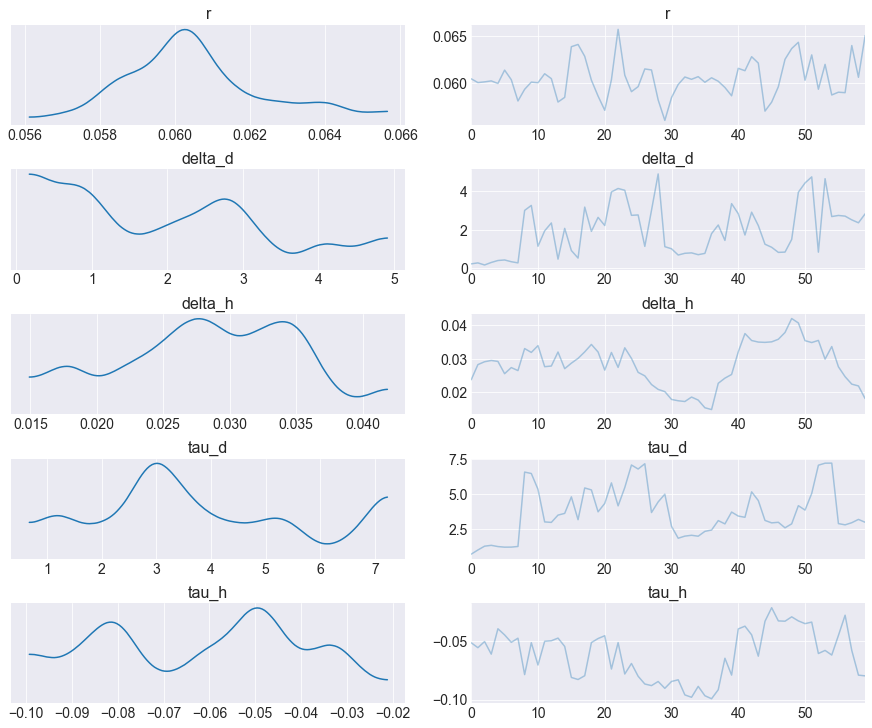

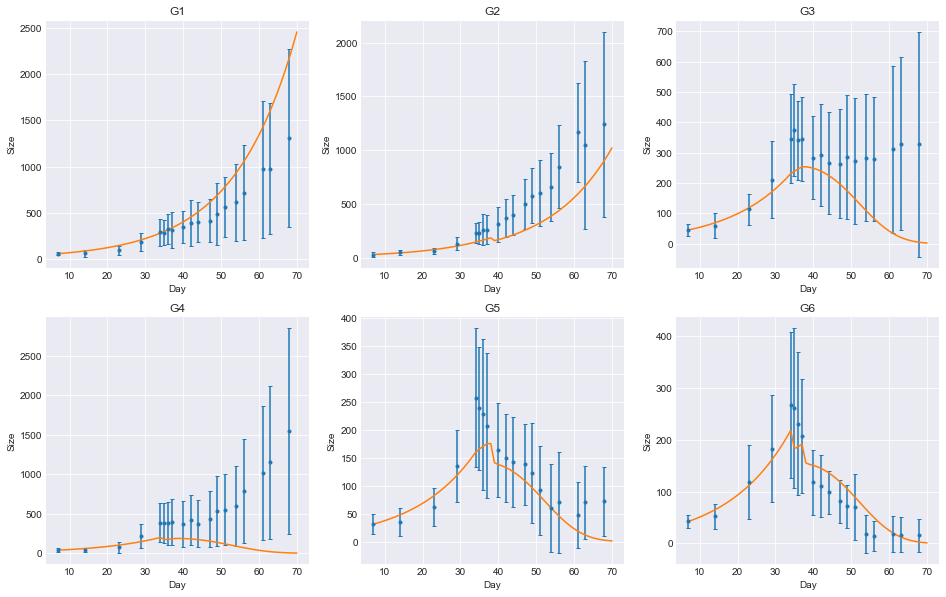

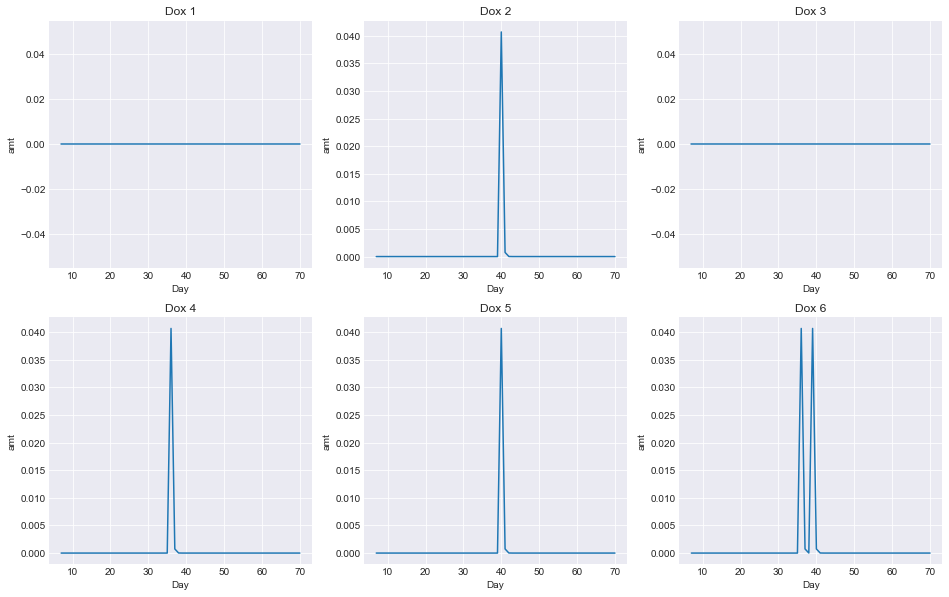

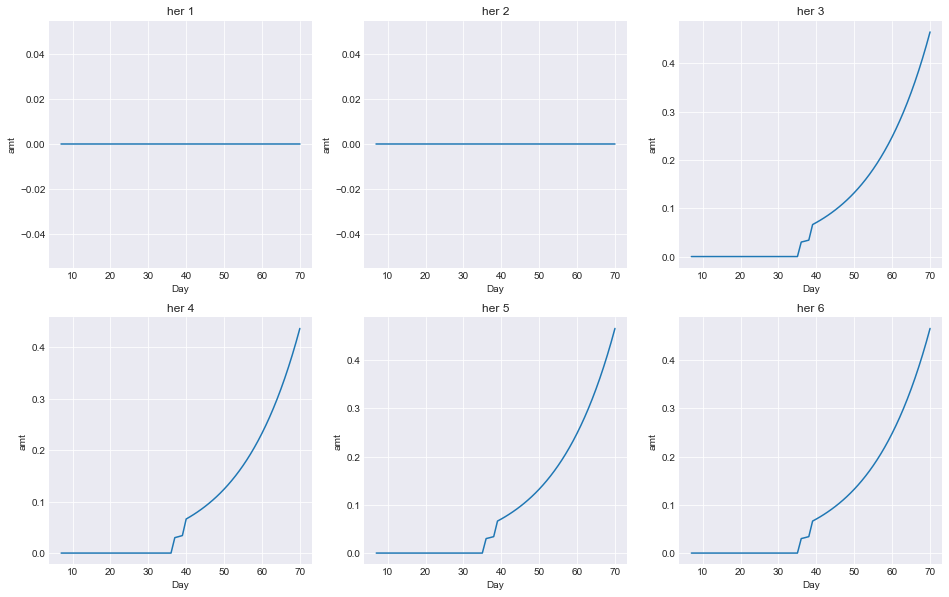

In [13]:
fit_sim_graph_model(exp_growth_model)

In [13]:

def fit_sim_graph_allee_model(model_class):
    this_model = model_class(ts, Ts[:,0])
    this_model.backward(Ts, sigmas)
    #delta_d, delta_h, tau_d, tau_h = this_model.get_treatment_params()
    #T_sim = this_model.simulate([this_model.get_param(x) for x in this_model.param_list])
    
    r, A, delta_d, delta_h, tau_d, tau_h= [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(r, A, delta_d, delta_h, tau_d, tau_h, sim_times)
    
    dox = np.zeros((6,len(sim_times.ravel())))
    her = np.zeros((6,len(sim_times.ravel())))
    for ii in range(len(sim_times)):
        T = T_sim[:,ii]
        t = sim_times[ii]
        dox[:,ii] = dox_treatment_all_inst(delta_d, T, tau_d, t)
        her[:,ii] = her_treatment_all_inst(delta_h, T, tau_h, t)
    graph_sim(sim_times, T_sim)
    graph_dox(sim_times, dox)
    graph_her(sim_times, her)

## Allee effect models

### Left column

#### Model 6
dTdt = (r-Sh)(1-A(1+Sd)/T)T

#### Model 7
dTdt = (r-Sd)(1-A(1+Sh)/T)T

#### Model 8
dTdt = r(1-A(1+Sd)/T)T-ShT

#### Model 9
dTdt = r(1-A(1+Sh)/T)T-SdT

#### Model 10
dTdt = (r-Sd-Sh)(1-A/T)T

#### Model 11
dTdt = r(1-A(1+Sh+Sd)/T)T

#### Model 12
dTdt = r(1-A/T)T - SdT - ShT



### right column

#### Model 13
dTdt = (r-Sh)(1-A(1+Sd)/T)T(1-T/K)

#### Model 14
dTdt = (r-Sd)(1-A(1+Sh)/T)T(1-T/K)

#### Model 15
dTdt = r(1-A(1+Sd)/T)T(1-T/K)-ShT

#### Model 16
dTdt = r(1-A(1+Sh)/T)T(1-T/K)-SdT

#### Model 17
dTdt = (r-Sd-Sh)(1-A/T)T(1-T/K)

#### Model 18
dTdt = r(1-A(1+Sh+Sd)/T)T(1-T/K)

#### Model 19
dTdt = r(1-A/T)T(1-T/K)-SdT-ShT



## Model 6
dTdt = (r-Sh)(1-A(1+Sd)/T)T


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:11<00:00,  1.20s/it]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


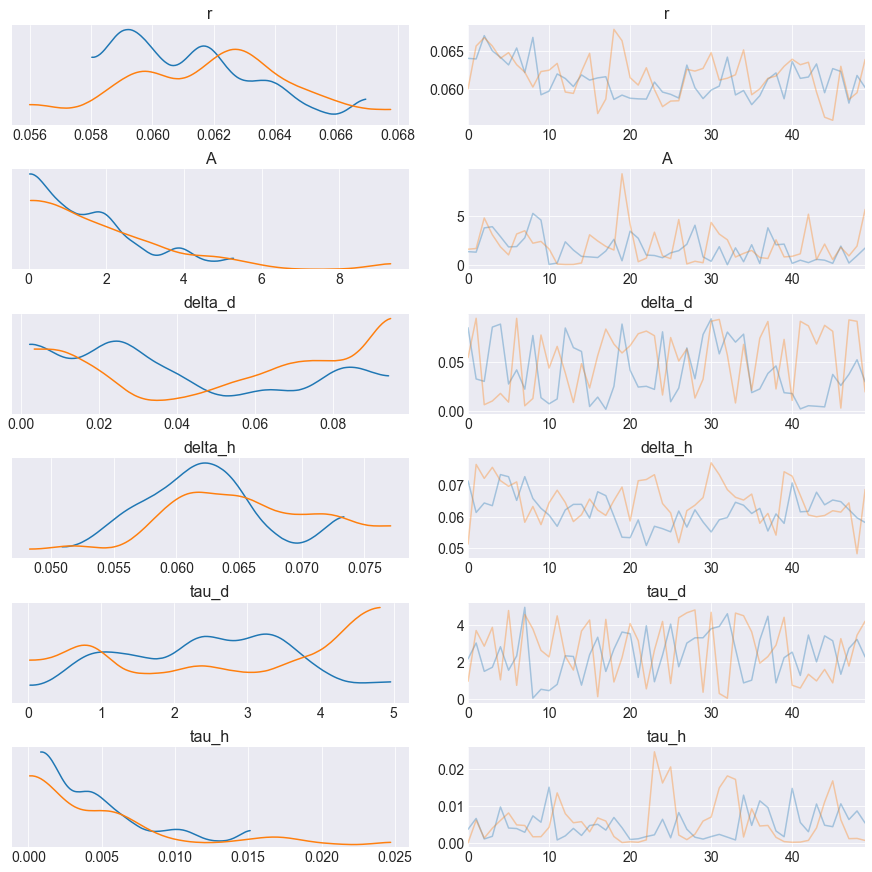

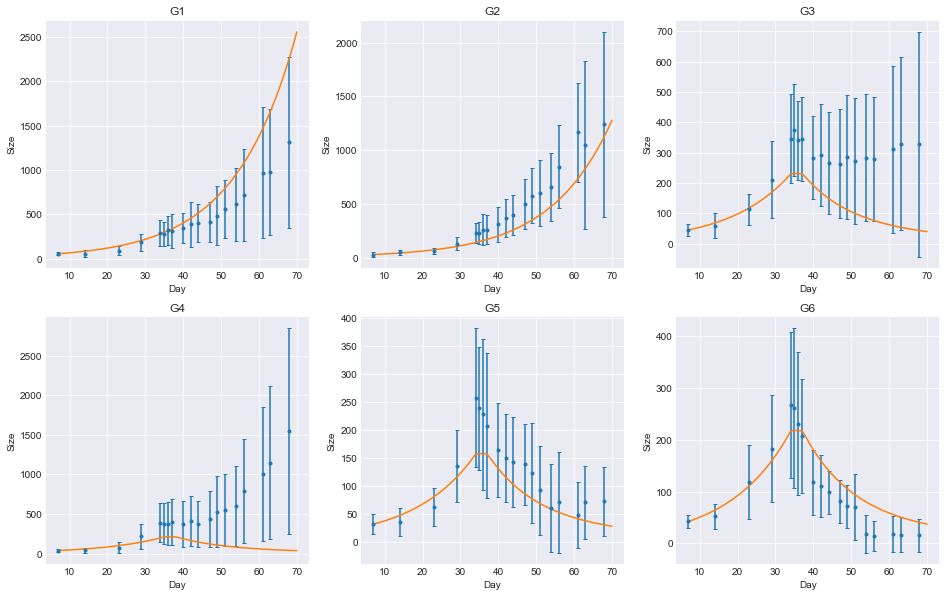

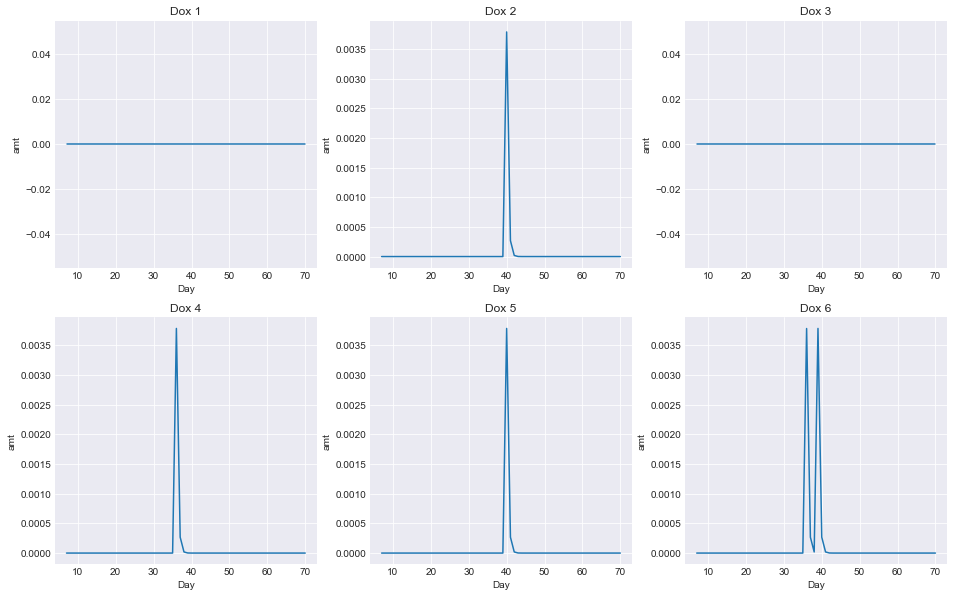

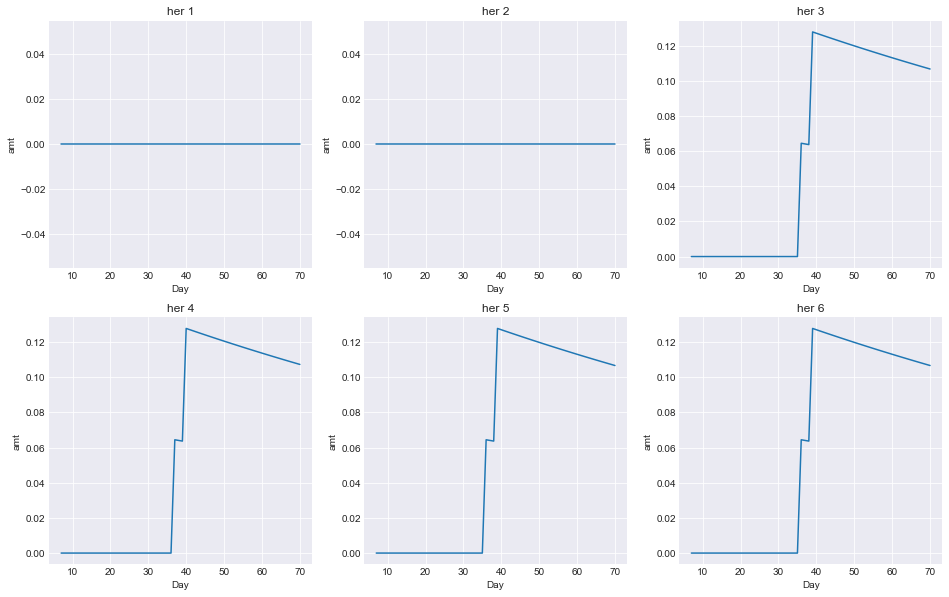

In [18]:

        
class growth_model_6(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params):
        r, A, delta_d, delta_h, tau_d, tau_h = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r-Sh)*(1-A*(1+Sd)/T)*T
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            self.param_list = ['r', 'A', 'delta_d', 'delta_h', 'tau_d', 'tau_h']
            r_lower = 0
            r_upper = 0.1
            A_lower = 0
            A_upper = 10
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 5
            tau_h_lower = 0
            tau_h_upper = 0.5
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, A, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 2
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       #'K':np.random.uniform(K_lower, K_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 50
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 

fit_sim_graph_allee_model(growth_model_6)


## model 7
dTdt = (r-Sd)(1-A(1+Sh)/T)T

Only 60 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:30<00:00,  1.26s/it]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


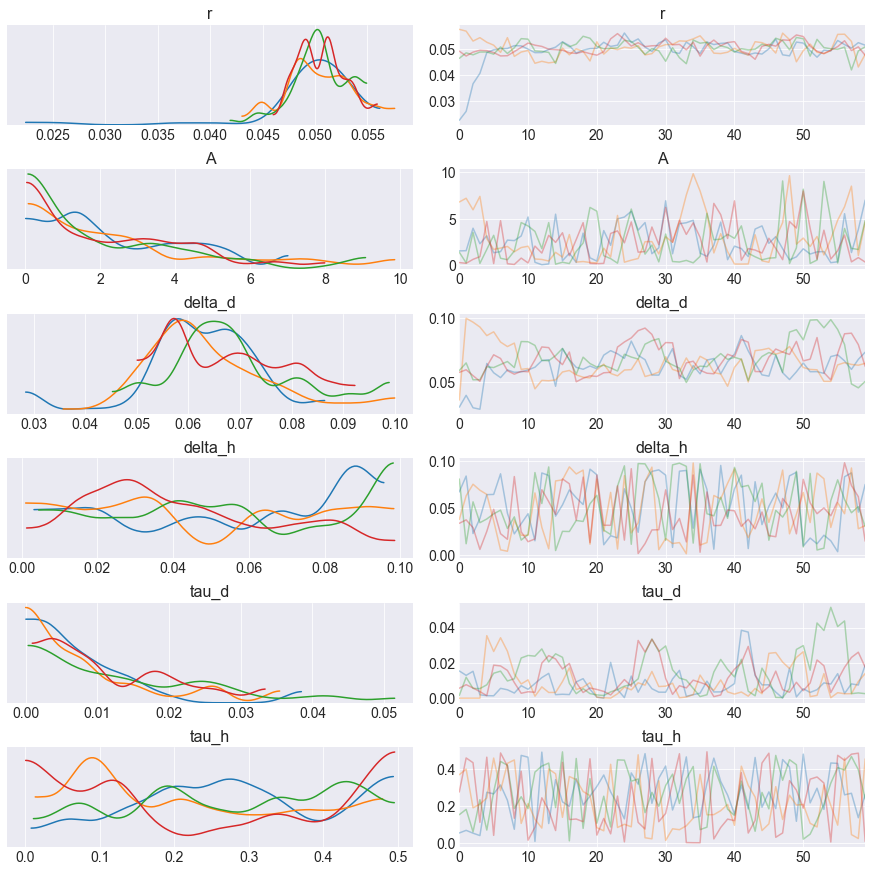

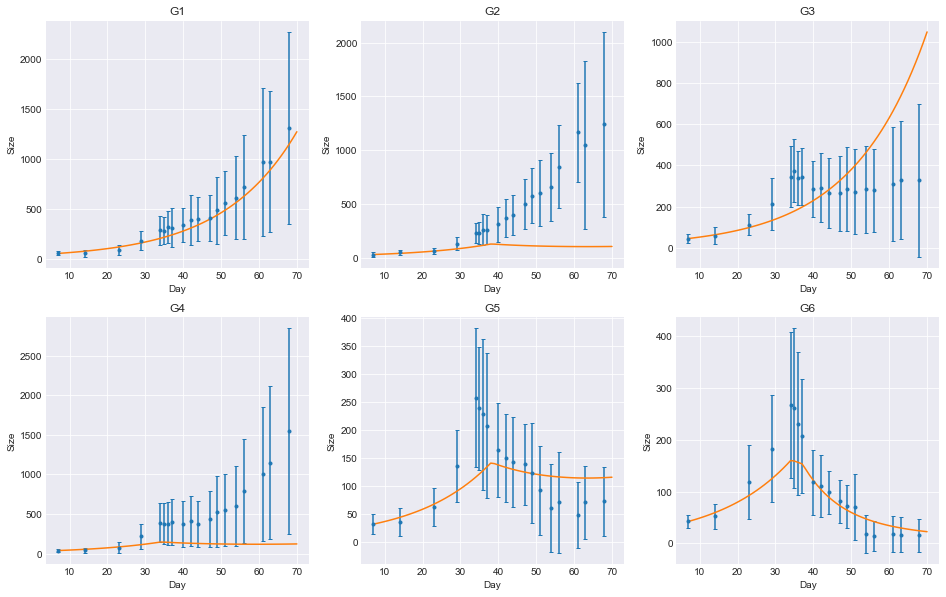

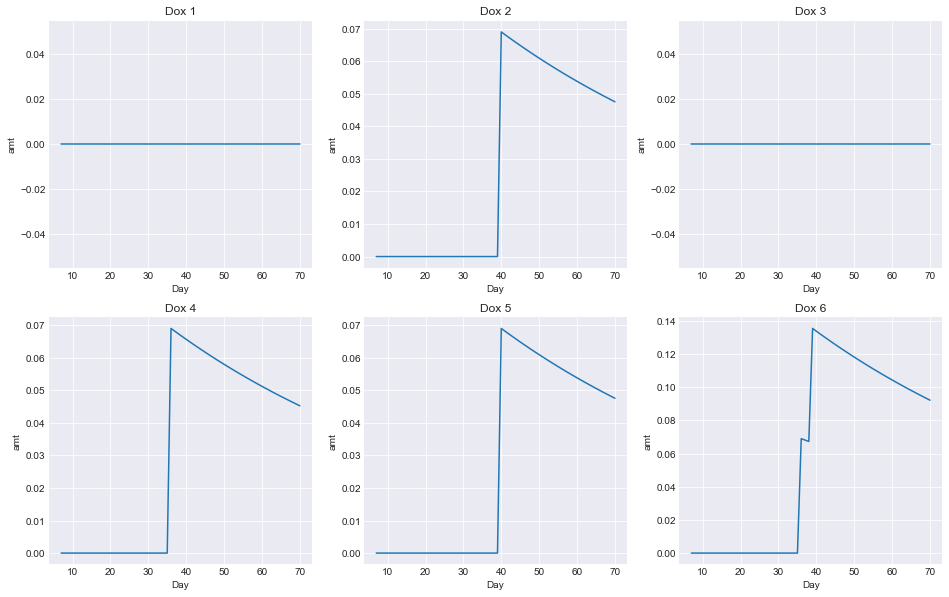

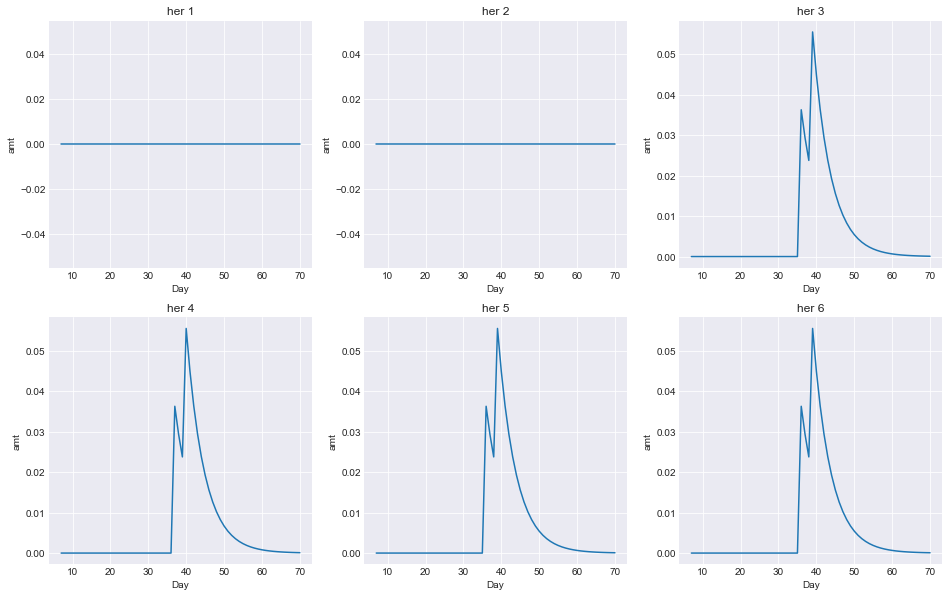

In [19]:

class growth_model_7(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params):
        r, A, delta_d, delta_h, tau_d, tau_h = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r-Sd)*(1-A*(1+Sh)/T)*T
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            self.param_list = ['r', 'A', 'delta_d', 'delta_h', 'tau_d', 'tau_h']
            r_lower = 0
            r_upper = 0.1
            A_lower = 0
            A_upper = 10
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 5
            tau_h_lower = 0
            tau_h_upper = 0.5
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)


            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, A, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 2
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 60
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def get_param(self, param_name, n=50):
        return sum(self.trace[param_name][-n:])/n
    
fit_sim_graph_allee_model(growth_model_7)

## Model 8
dTdt = r(1-A(1+Sd)/T)T-ShT

Only 60 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [14:20<00:00, 11.95s/it]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


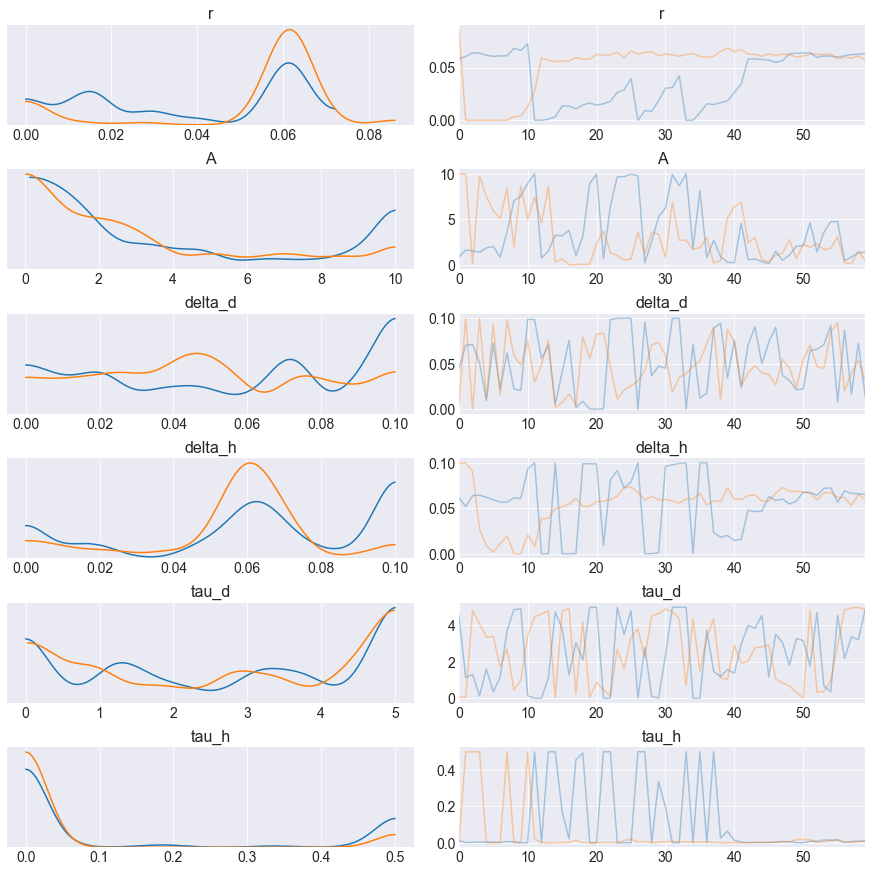

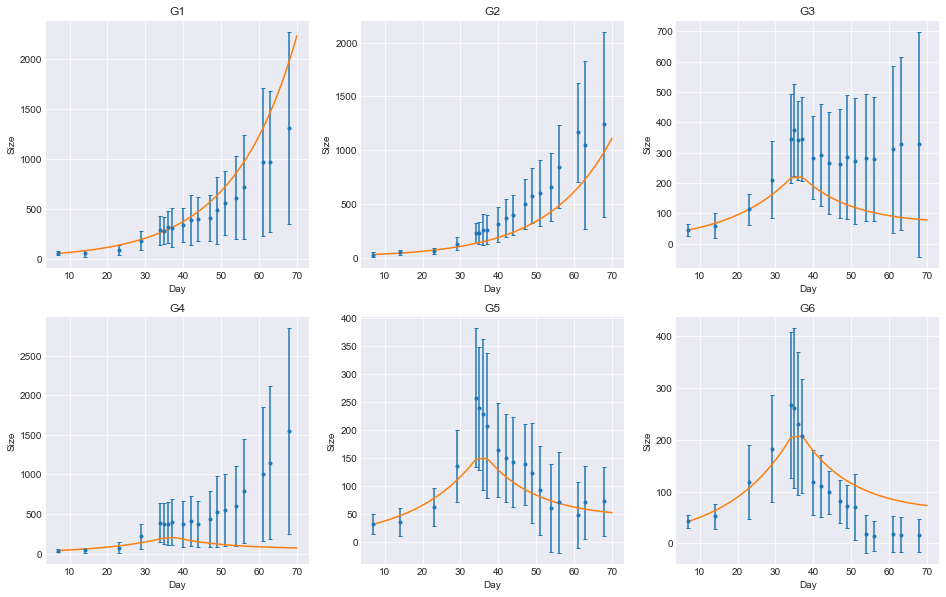

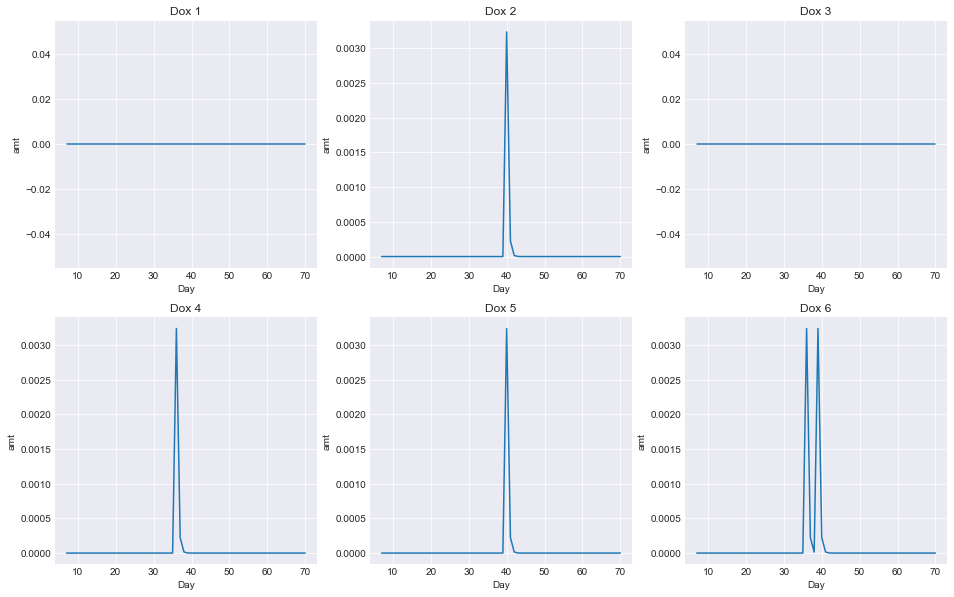

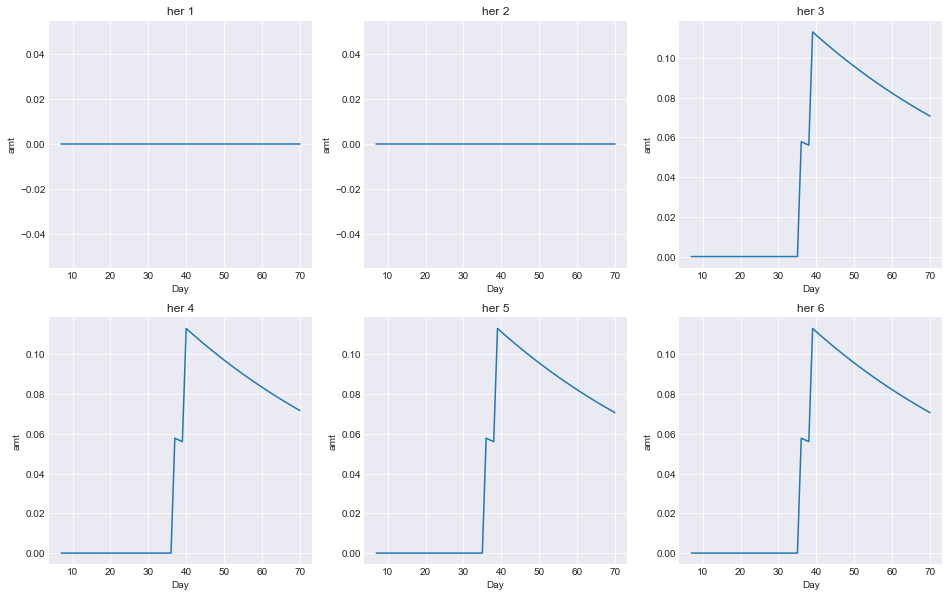

In [14]:

class growth_model_8(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params):
        r, A, delta_d, delta_h, tau_d, tau_h = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r*(1-A*(1+Sd)/T)-Sh)*T
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            self.param_list = ['r', 'A', 'delta_d', 'delta_h', 'tau_d', 'tau_h']
            r_lower = 0
            r_upper = 0.1
            A_lower = 0
            A_upper = 10
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 5
            tau_h_lower = 0
            tau_h_upper = 0.5
            
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)


            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, A, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 2
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 60
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    
fit_sim_graph_allee_model(growth_model_8)

## Model 9

dTdt = r(1-A(1+Sh)/T)T-SdT



Only 60 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:03<00:00,  1.14it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


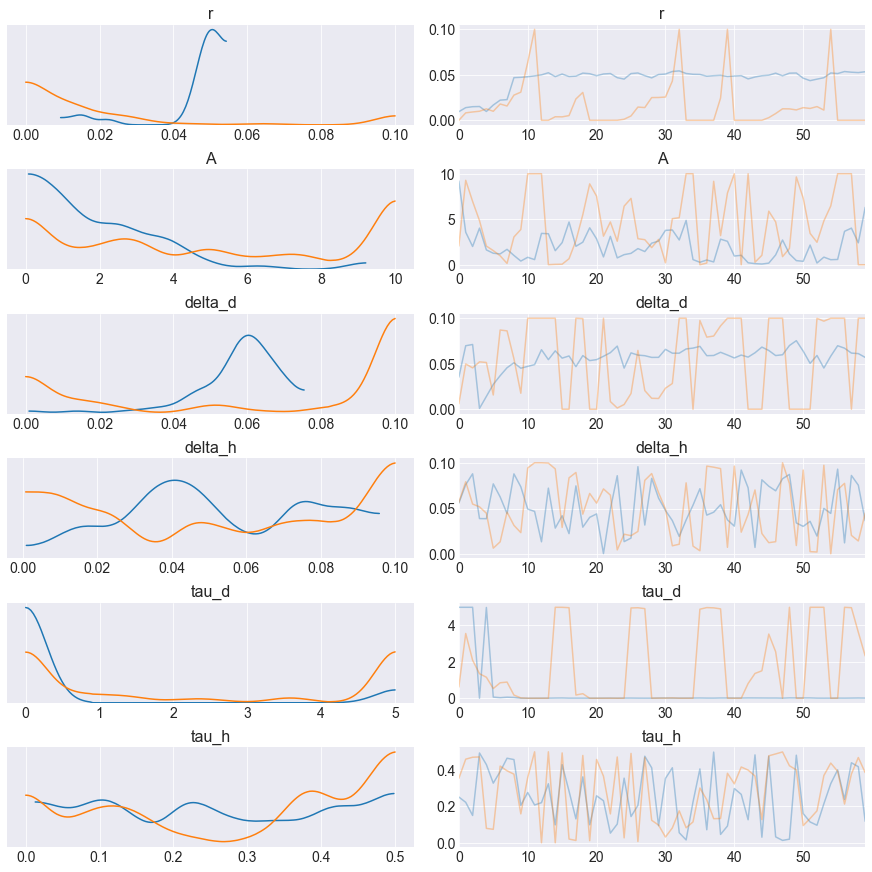

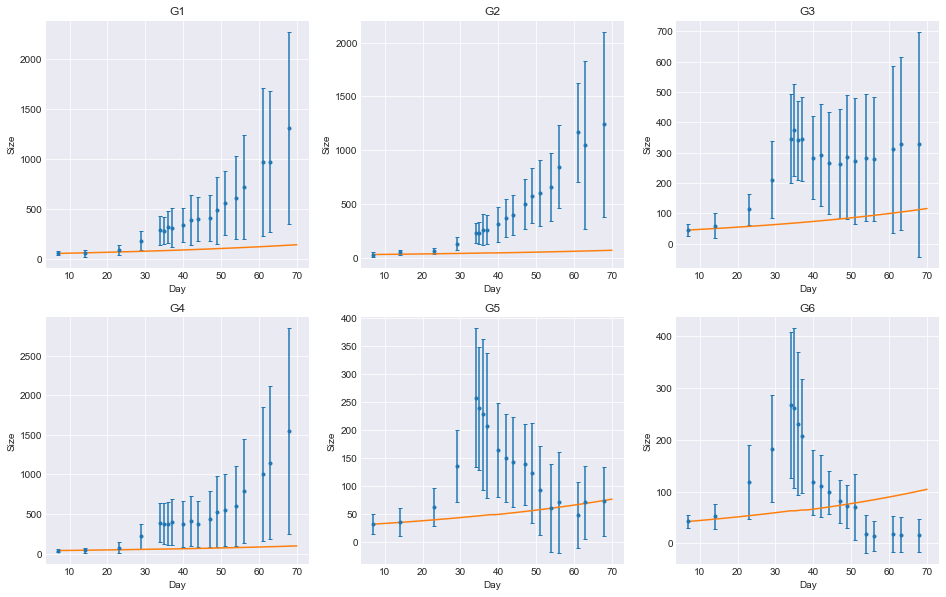

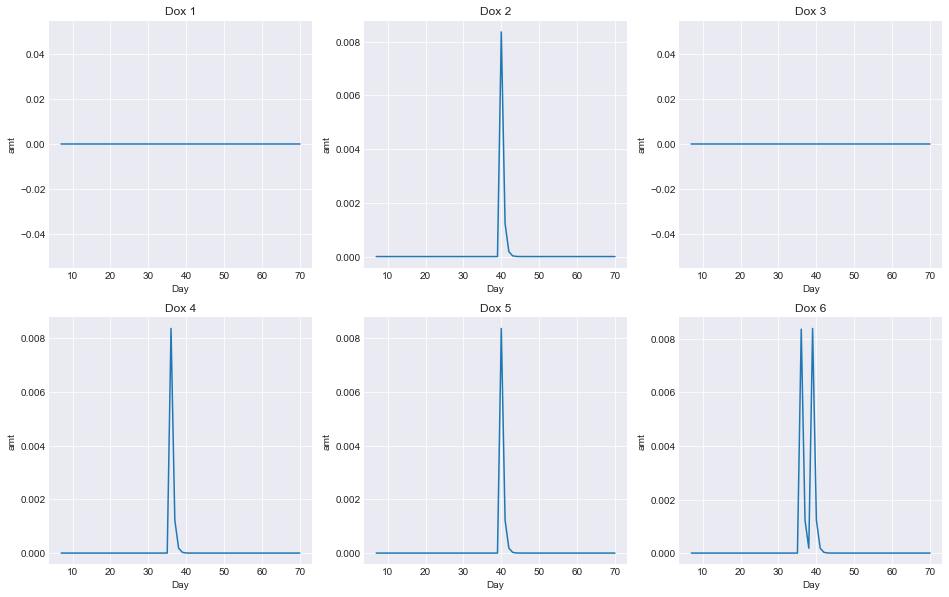

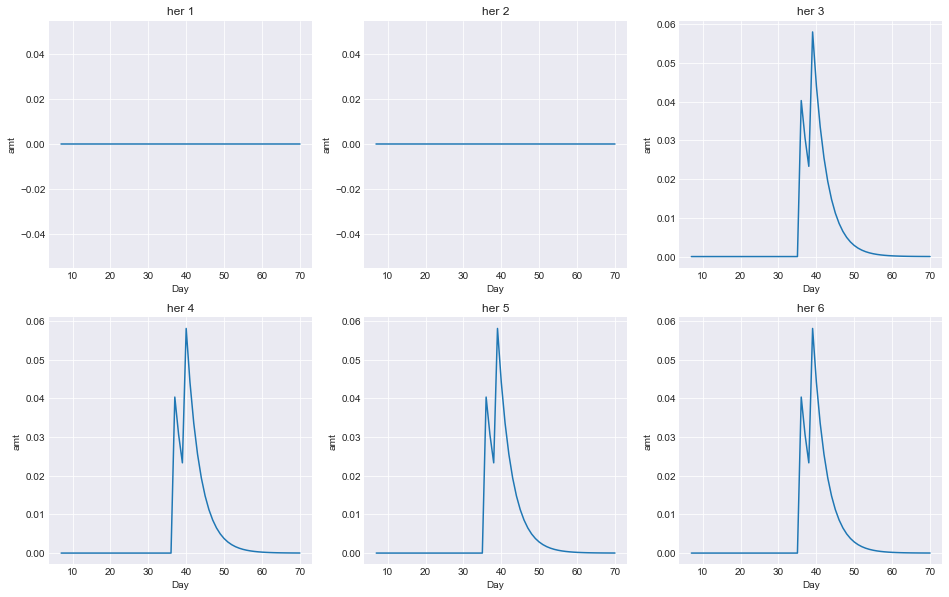

In [15]:

class growth_model_9(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params):
        r, A, delta_d, delta_h, tau_d, tau_h = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r*(1-A*(1+Sh)/T)-Sd)*T
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            self.param_list = ['r', 'A', 'delta_d', 'delta_h', 'tau_d', 'tau_h']
            r_lower = 0
            r_upper = 0.1
            A_lower = 0
            A_upper = 10
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 5
            tau_h_lower = 0
            tau_h_upper = 0.5
            
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)


            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, A, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 2
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 60
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    
fit_sim_graph_allee_model(growth_model_9)

## Model 10

dTdt = (r-Sd-Sh)(1-A/T)T

Only 60 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [tau_d]
>Slice: [delta_h]
>Slice: [delta_d]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:09<00:00,  1.03it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


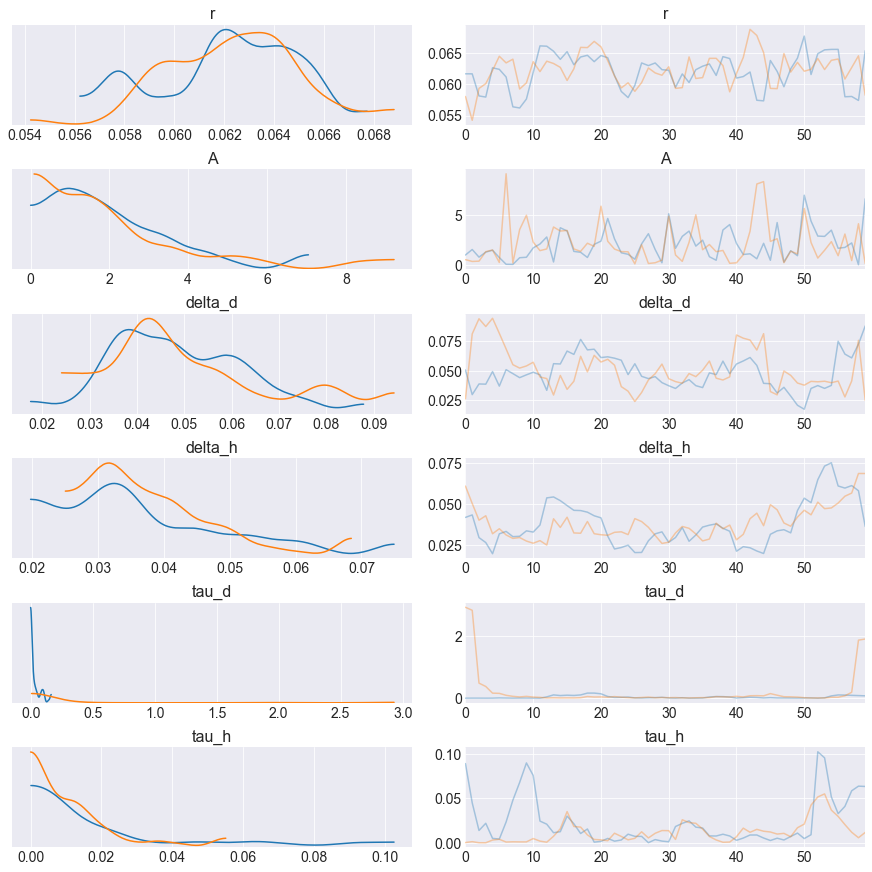

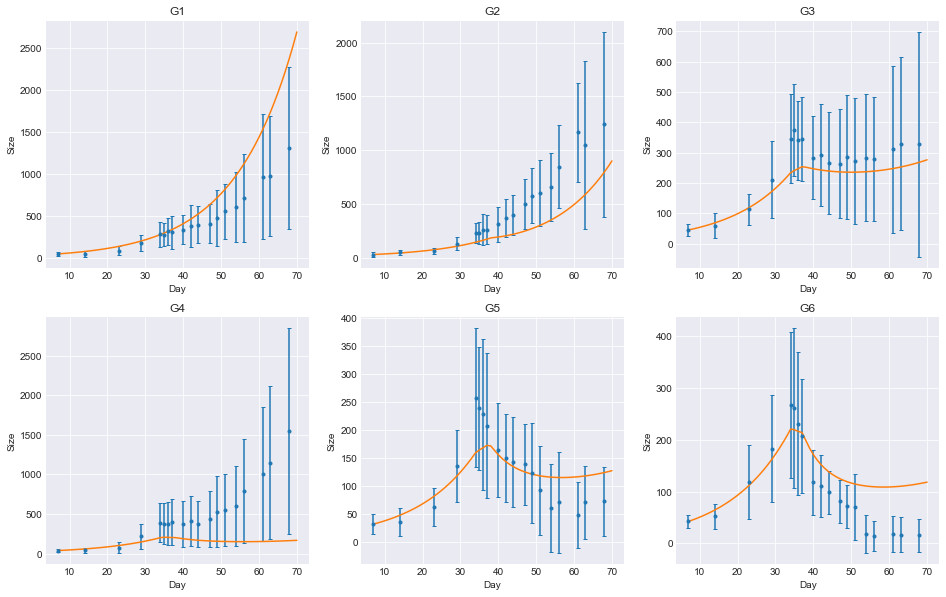

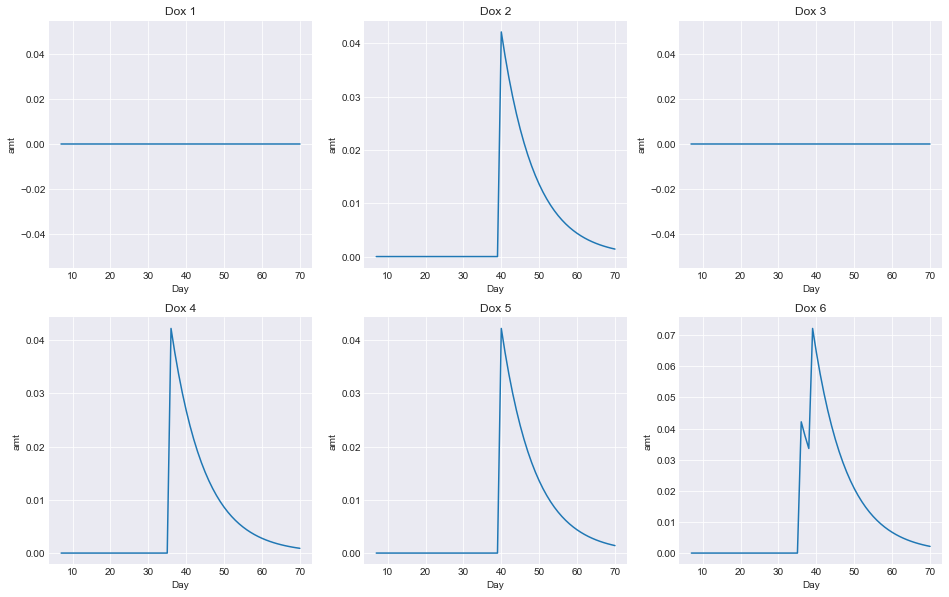

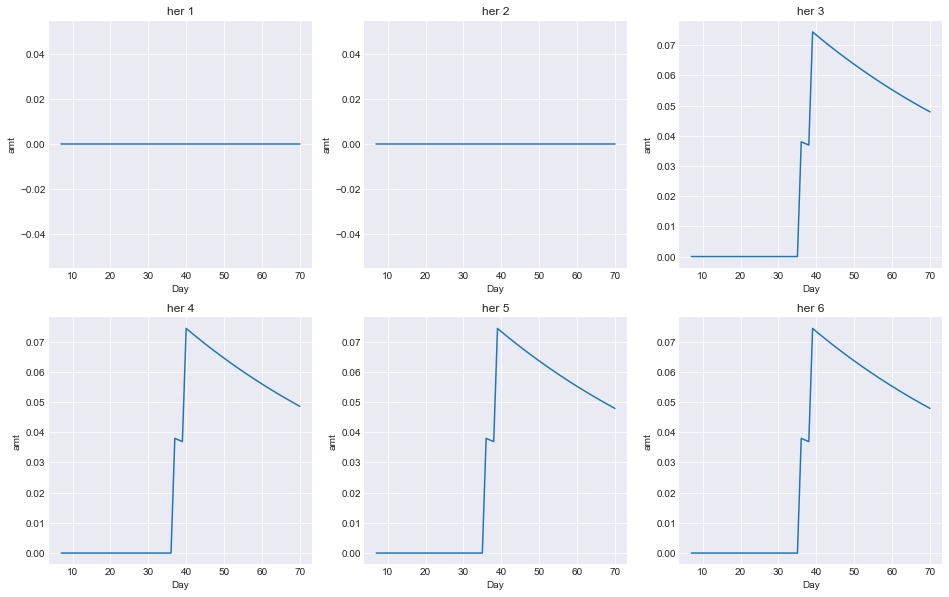

In [16]:

class growth_model_10(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_h, tau_d, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_h, tau_d, tau_h], times)
    
    def dTdt(self, t, T, params):
        r, A, delta_d, delta_h, tau_d, tau_h = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        Sh = her_treatment_all_inst(delta_h, T, tau_h, t)
        return (r-Sd-Sh)*(1-A/T)*T
    
    def backward(self, T_obs, sigmas):
        with pm.Model():
            self.param_list = ['r', 'A', 'delta_d', 'delta_h', 'tau_d', 'tau_h']
            r_lower = 0
            r_upper = 0.1
            A_lower = 0
            A_upper = 10
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_h_lower = 0
            delta_h_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 5
            tau_h_lower = 0
            tau_h_upper = 0.5
            
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)


            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h):
                th_states = self.simulate(r, A, delta_d, delta_h, tau_d, tau_h)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_h, tau_d, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 2
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 60
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
    
fit_sim_graph_allee_model(growth_model_10)